# Split in Local Development

In the first phase of the competition there is a development test which is used as first test in CodaBench. In this notebook we are going to split the training set again, generating a new development set.

Different strategies may be followed:
- Random split: Just getting, for example, 10% of the training set as development set.
- Avoid overlapping between train gold standard and development gold standard
- Avoid posts overlapping between train and development


## Monolingual Task Split

Logically, it will be done in the same way for all languages.

In [1]:
from src.datasets import TextConcatPosts, Dataset

tasks_path = "data/complete_data/tasks.json" # This is the file that will be replaced in the final version with new split
posts_path = "data/complete_data/posts.csv"
fact_checks_path = "data/complete_data/fact_checks.csv"
gs_path = "data/complete_data/pairs.csv"

posts = TextConcatPosts(posts_path, tasks_path, task_name="monolingual", gs_path=gs_path)
# fact_checks = BaseFactCheckDataset(fact_checks_path, tasks_path, task_name="monolingual")

# df_fc = fact_checks.df
df_posts_train = posts.df_train

## Duplicated Values

It would be very easy for the model to predict the fact checking label of a post if it has already seen it in the training set. Therefore, we should avoid having the same post in both the training and development sets.

This task is not completely straightforward, as we have to take into account that the same post can be written in slightly different ways. For example with different amount of spaces, emojis, caps, etc.

Possibilities:
- `text`is empty but there is `ocr`: Check duplicates in `full_text`
- `text` is not empty and duplicated but `ocr` is not: not duplicated

Duplicated = same `full_text` (OCR + text)

In [2]:
full_text_dup = df_posts_train.duplicated(subset=["full_text"], keep=False)#& (df_posts_train.full_text != "")
text_dup = df_posts_train.duplicated(subset=["text"], keep=False) & (df_posts_train.text != "")

In [3]:
print("[OCR + Text] total duplicates", df_posts_train["full_text"].duplicated().sum(), f"({df_posts_train['full_text'].duplicated().mean()})")
print("[Text] total duplicates", df_posts_train.loc[df_posts_train.text != '', 'text'].duplicated().sum(), f"({df_posts_train.loc[df_posts_train.text != '', 'text'].duplicated().mean()})")
df_posts_train[full_text_dup].sort_values("full_text").head(4)

[OCR + Text] total duplicates 27 (0.006205470006894967)
[Text] total duplicates 60 (0.01576872536136662)


,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
4809,,False information,"A 40-ton truck lifted by 2,000 drones [URL]",eng,1,0,0,"A 40-ton truck lifted by 2,000 drones [URL]",[132558]
4810,,,"A 40-ton truck lifted by 2,000 drones [URL]",eng,0,1,0,"A 40-ton truck lifted by 2,000 drones [URL]",[132558]
6945,,False information.,Breaking News: Trump Rejects New Arms Deal wit...,eng,2,0,0,Breaking News: Trump Rejects New Arms Deal wi...,[133966]
6946,,,Breaking News: Trump Rejects New Arms Deal wit...,eng,1,0,0,Breaking News: Trump Rejects New Arms Deal wi...,[133966]


## Effective indices

In [4]:
def get_split_indices(df, test_size=0.1, random_state=42, stratify_by=None):
    
    dup_criteria = df.duplicated(subset=["full_text"], keep=False)#& (df_posts_train.full_text != "")

    df_dups = df[dup_criteria].copy()
    df_not_dups = df[~dup_criteria].copy()

    # idxs_dev = df_not_dups.sample(frac=test_size, random_state=random_state).index

    # idx_train = df_not_dups.index.difference(idxs_dev).union(df_dups.index)
    
    from sklearn.model_selection import train_test_split
    idx_train, idxs_dev = train_test_split(df_not_dups.index, test_size=test_size, random_state=random_state)
    
    if stratify_by is not None:
        print(df_not_dups[stratify_by].value_counts())
        idx_train, idxs_dev = train_test_split(df_not_dups.index, test_size=test_size, random_state=random_state, stratify=df_not_dups[stratify_by].values)
    
    idx_train = idx_train.union(df_dups.index)

    print("Total", len(df))
    print("Train", len(idx_train))
    print("Dev", len(idxs_dev))

    assert len(df) == len(idx_train) + len(idxs_dev)


    return idx_train.tolist(), idxs_dev.tolist()

In [5]:
idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)

Total 4351
Train 3921
Dev 430


In [6]:
posts.df_dev.shape[0] / df_posts_train.shape[0]

0.10985980234428867

# Cross-lingual Task Split

In this case, it could happen that there is literally the same post in two different languages. In this case, we should avoid having the same post in both the training and development sets. For that, some scores of parallelism between the posts in different languages could be calculated.

Also, and more important, it is possible that there is more imbalance in the training set for some languages than for others. In this case, we should take into account the language when splitting the training set, stratifying by language.

In [7]:
posts_xl = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
# fact_checks = BaseFactCheckDataset(fact_checks_path, tasks_path, task_name="monolingual")

# df_fc = fact_checks.df
df_posts_train_xl = posts_xl.df_train

In [8]:
df_posts_train_xl.sample(5)

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
15920,"SPÉCIAL LAÏCS, OUI, FACHOS, NON! CHARLIE HEBD ...",False information,Os franceses fazem chacota do STF brasileiro.,por,1,0,0,"SPÉCIAL LAÏCS, OUI, FACHOS, NON! CHARLIE HEBD ...","[36894, 113671]"
6242,Charme Listene Audrey Courreges [USER] Infirmi...,False information,Audrey Courreges - Infirmière... 🖖,fra,1,0,0,Charme Listene Audrey Courreges [USER] Infirmi...,[79534]
11115,,False information,HINCHADA DE FLAMENGO ECHÓ CAGANDO DEL ESTADIO ...,spa,1,0,0,HINCHADA DE FLAMENGO ECHÓ CAGANDO DEL ESTADIO...,[51321]
1584,OC Por que essa mulher ligou 18 vezes para Adé...,False information,,por,1,0,0,OC Por que essa mulher ligou 18 vezes para Adé...,"[86648, 86649]"
23754,,Altered photo,ڈیزل کہ چاہنے والے.... جو عالم مانتے ہیں.........,other,2,0,0,ڈیزل کہ چاہنے والے.... جو عالم مانتے ہیں........,[103821]


In [9]:
idx_train_xl, idxs_dev_xl = get_split_indices(df_posts_train_xl, test_size=0.1, random_state=42, stratify_by="lan")

lan
other    2375
spa       787
eng       626
por       369
fra       254
msa       184
ara       136
tha       106
deu        88
            2
Name: count, dtype: int64
Total 4972
Train 4479
Dev 493


<Axes: >

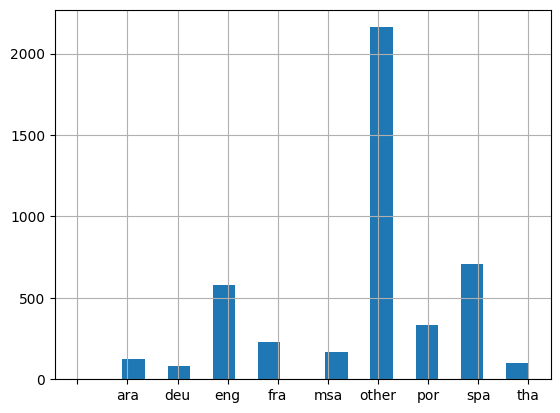

In [10]:
df_posts_train_xl.loc[idx_train_xl, "lan"].sort_values().hist(bins=20)

<Axes: >

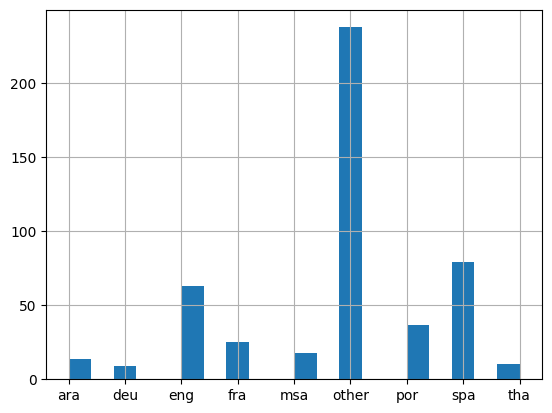

In [11]:
df_posts_train_xl.loc[idxs_dev_xl, "lan"].sort_values().hist(bins=20)

# Index Creation

In [12]:
from tqdm import tqdm
new_tasks_mono = posts.tasks["monolingual"].copy()

for lan in tqdm(new_tasks_mono.keys()):
    posts = TextConcatPosts(posts_path, tasks_path, task_name="monolingual", gs_path=gs_path, lang=lan)
    df_posts_train = posts.df_train

    idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)
    
    new_tasks_mono[lan]["posts_train"] = idx_train
    new_tasks_mono[lan]["posts_dev"] = idxs_dev

 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]

Total 1596
Train 1437
Dev 159


 25%|██▌       | 2/8 [00:04<00:13,  2.31s/it]

Total 5628
Train 5070
Dev 558


 38%|███▊      | 3/8 [00:06<00:10,  2.14s/it]

Total 4351
Train 3921
Dev 430


 50%|█████     | 4/8 [00:08<00:08,  2.05s/it]

Total 2571
Train 2315
Dev 256


 62%|██████▎   | 5/8 [00:10<00:05,  1.96s/it]

Total 465
Train 418
Dev 47


 75%|███████▌  | 6/8 [00:12<00:03,  1.93s/it]

Total 667
Train 600
Dev 67


 88%|████████▊ | 7/8 [00:13<00:01,  1.90s/it]

Total 1062
Train 957
Dev 105


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]

Total 676
Train 608
Dev 68


In [13]:
posts_xl = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train_xl = posts_xl.df_train

new_tasks_xl = posts.tasks["crosslingual"].copy()

posts = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train = posts.df_train

idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)

new_tasks_xl["posts_train"] = idx_train
new_tasks_xl["posts_dev"] = idxs_dev

Total 4972
Train 4479
Dev 493


In [14]:
new_tasks = posts.tasks.copy()
new_tasks["monolingual"] = new_tasks_mono
new_tasks["crosslingual"] = new_tasks_xl

In [15]:
for lan in new_tasks["monolingual"].keys():
    print(lan, len(new_tasks["monolingual"][lan]["posts_train"]), len(new_tasks["monolingual"][lan]["posts_dev"]))
    
print("cross", len(new_tasks["crosslingual"]["posts_train"]), len(new_tasks["crosslingual"]["posts_dev"]))

fra 1437 159
spa 5070 558
eng 3921 430
por 2315 256
tha 418 47
deu 600 67
msa 957 105
ara 608 68
cross 4479 493


In [16]:
for lan in posts.tasks["monolingual"].keys():
    print(lan, len(posts.tasks["monolingual"][lan]["posts_train"]), len(posts.tasks["monolingual"][lan]["posts_dev"]), len(posts.tasks["monolingual"][lan]["posts_dev"]) / len(posts.tasks["monolingual"][lan]["posts_train"]))
    
print("cross", len(posts.tasks["crosslingual"]["posts_train"]), len(posts.tasks["crosslingual"]["posts_dev"]))

fra 1596 188 0.11779448621553884
spa 5628 615 0.10927505330490406
eng 4351 478 0.10985980234428867
por 2571 302 0.11746402178140801
tha 465 42 0.09032258064516129
deu 667 83 0.12443778110944528
msa 1062 105 0.09887005649717515
ara 676 78 0.11538461538461539
cross 4972 552


In [17]:
import json
tasks_path = "data/splits/tasks_local_dev.json"

with open(tasks_path, "w") as f:
    json.dump(new_tasks, f, indent=4)

# Check it is working

In [24]:
from src.datasets import TextConcatPosts, Dataset

tasks_path = "data/splits/tasks_local_dev.json" # This is the file that will be replaced in the final version with new split
posts_path = "data/complete_data/posts.csv"
fact_checks_path = "data/complete_data/fact_checks.csv"
gs_path = "data/complete_data/pairs.csv"

posts = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train = posts.df_train
df_posts_dev = posts.df_dev

In [25]:
df_posts_train.head()

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
3,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",False,,fra,0,0,1,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",[50973]
16,"""Estrictamente y hablando con sentido, la conq...",Partly false information,,spa,1,0,0,"""Estrictamente y hablando con sentido, la conq...",[38000]
30,"""No es necesario creer en Dios para ser una bu...",False information,,spa,1,0,0,"""No es necesario creer en Dios para ser una bu...",[3857]
60,#Artés Presidente #Save Palestine ... [USER] M...,Partly false information,,spa,1,0,0,#Artés Presidente #Save Palestine ... [USER] M...,[50802]
62,#CNN: Child soldiers are ok if they are to def...,Altered photo,,eng,1,0,0,#CNN: Child soldiers are ok if they are to def...,"[34139, 134205]"


In [26]:
posts.langs

['fra', 'spa', 'eng', 'por', 'tha', 'deu', 'msa', 'ara']

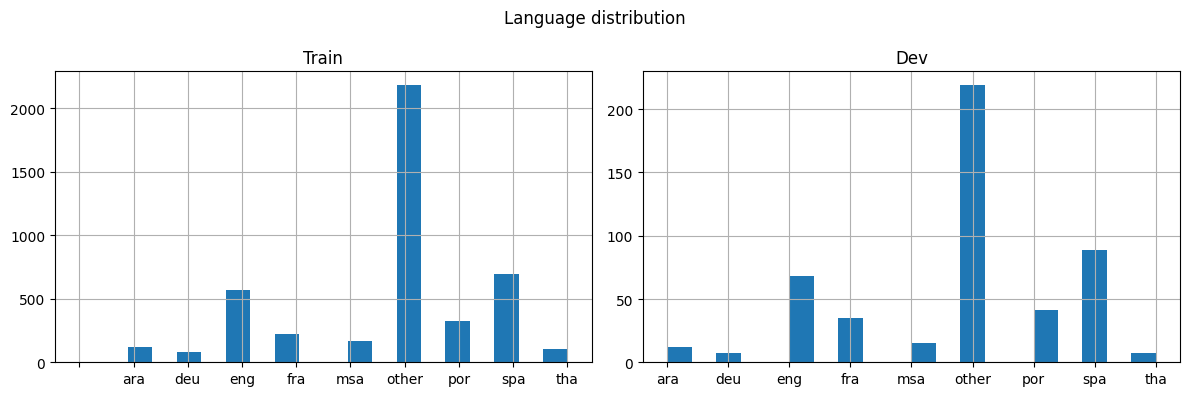

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

df_posts_train["lan"].sort_values().hist(bins=20, ax=ax[0])
df_posts_dev["lan"].sort_values().hist(bins=20, ax=ax[1])

ax[0].set_title("Train")
ax[1].set_title("Dev")

fig.suptitle("Language distribution")
fig.tight_layout()


In [22]:

ds = Dataset(posts_path, tasks_path, task_name="crosslingual")
ds.df.head()

,post_id,instances,ocr,verdicts,text
0,0,"[(1608571882.0, fb)]",[(! Dreister Impf-Fake von Markus Söder! Es is...,['False information'],
1,1,"[(1586139153.0, fb)]",[(!! WARNING !! A new thing circulating now. P...,['False information'],
2,2,"[(1610052141.0, fb), (1610072448.0, fb)]","[(""Actually, he's a damn sight better than any...",['Missing context'],
3,3,"[(1645187790.0, ig)]","[(""Australia 50 MILLONES de dosis de ""vacuna"" ...",['False'],
4,4,"[(1581697500.0, fb)]","[(""Bienaventurados los perseguidos por mi caus...",[],


In [23]:
ds.df["ocr"].apply(lambda x: x[0][-1][0][0] if (isinstance(x, list)&len(x)>0) else "")

0        deu
1        eng
2        eng
3        fra
4        spa
        ... 
24426       
24427    eng
24428       
24429    eng
24430    kor
Name: ocr, Length: 24431, dtype: object